In [1]:
import numpy as np
from keras.models import  Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import LSTM
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#import seaborn as sns

In [6]:
df=pd.read_csv("D:\\360Downloads\\WeChat Files\\zhaojinghan111\\FileStorage\\File\\2024-04\\AAPL.csv",parse_dates=["Date"],index_col=[0])
# 读取文件，并转换为dateframe对象，将date列解析为日期格式；并将第一列设为索引

In [7]:
print(df.index.freq)
#索引频率（每日/月/年）；除非在创建dataframe 时明确设定，
#否则通常返回 none

None


In [8]:
df = df.iloc[:, :-1]

In [9]:
# 表示有5203行， 5 列
print(df.shape)

(2517, 5)


In [10]:
#返回前五行；df.head(10)
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2014-03-27,19.286428,19.339287,19.111429,19.195000,16.907249
2014-03-28,19.225714,19.247856,19.080357,19.173571,16.888372
2014-03-31,19.258215,19.314644,19.140356,19.169287,16.884605
2014-04-01,19.205713,19.352501,19.170357,19.344643,17.039061
2014-04-02,19.370714,19.410000,19.295000,19.376785,17.067366


In [11]:
df.tail()

,Open,High,Low,Close,Adj Close
Date,,,,,
2024-03-20,175.720001,178.669998,175.089996,178.669998,178.669998
2024-03-21,177.050003,177.490005,170.839996,171.369995,171.369995
2024-03-22,171.759995,173.050003,170.059998,172.279999,172.279999
2024-03-25,170.570007,171.940002,169.449997,170.850006,170.850006
2024-03-26,170.000000,171.419998,169.580002,169.710007,169.710007


In [12]:
test_split=round(len(df)*0.20)
# 先通过len（df）确定dataframe的长度，即行数；乘以0.2得到20%的数据行数；
#round 四舍五入； 将数据分割成训练集和测试集，其中测试占20%；这里注意不能打乱数据顺序，时间序列必须是顺序的

In [13]:
test_split

503

In [14]:
df_for_training=df[:-503]
df_for_testing=df[-503:]
#创建2个新的df：从开始到倒数第1041行；最后1041行

In [15]:
print(df_for_training.shape)
print(df_for_testing.shape)

(2014, 5)
(503, 5)


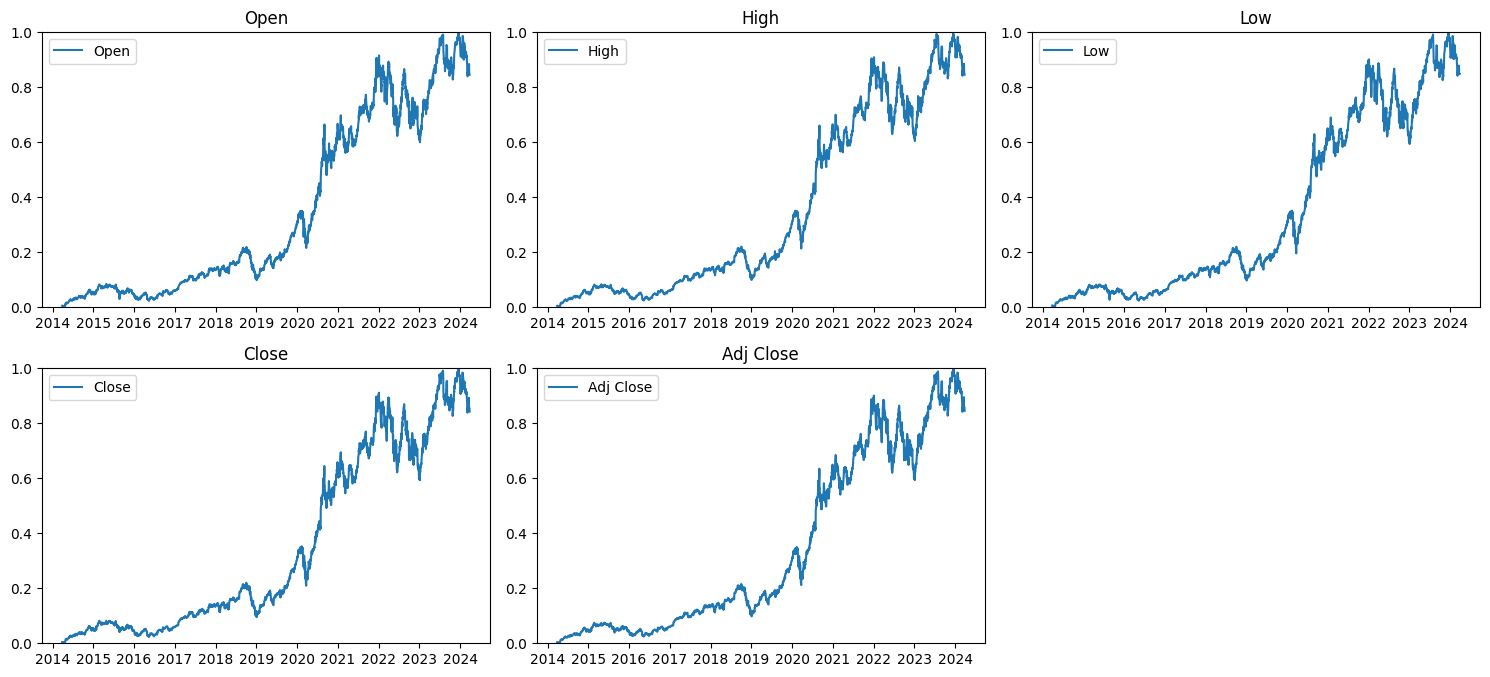

In [16]:
dim_names = ['Open', 'High', 'Low', 'Close', 'Adj Close']

# 数据归一化
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[dim_names])
df_scaled = pd.DataFrame(df_scaled, columns=dim_names, index=df.index)

# 创建归一化数据的子图，设置相同的y轴尺度
plt.figure(figsize=(15, 10))  # 调整图形尺寸以获得更好的可读性
for i, dim in enumerate(dim_names):
    plt.subplot(3, 3, i+1)
    plt.plot(df_scaled.index, df_scaled[dim], label=dim)
    plt.ylim(0, 1)  # 设置y轴的范围
    plt.title(dim)
    plt.legend()

plt.tight_layout()  # 调整布局以防止重叠
plt.show()  # 显示图表

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
# minmaxscaler是特征缩放技术，将最小特征值转换为0，最大特征值转换为1，其他数据线性缩放
# fit部分计算df_for_training 的最大/小值。缩放后的数据被储存在df_for_training_scaled 中；
# 特征缩放的目的是为了处理在数量级或单位上有很大差异的特征，通过确保各项特征都在相同维度上，可以帮助算法更好的学习模型

In [19]:
df_for_training_scaled

array([[0.00478067, 0.00443578, 0.00528194, 0.00425921, 0.00375339],
       [0.00441075, 0.00387939, 0.00508877, 0.00412815, 0.00363789],
       [0.00460877, 0.00428582, 0.00546177, 0.00410195, 0.00361484],
       ...,
       [0.89569125, 0.91772632, 0.91166139, 0.91933293, 0.92160604],
       [0.91080145, 0.93732109, 0.92869496, 0.92783386, 0.93001501],
       [0.92950629, 0.94644908, 0.94460968, 0.95144078, 0.95336674]])

In [20]:
df_for_training_scaled.shape


(2014, 5)

In [21]:
df_for_testing_scaled.shape

(503, 5)

In [22]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0]) # 目标是 open
    return np.array(dataX),np.array(dataY)
#首先定义两个空白列表，dataset 表示你要处理的数据；n_past 表示 想要查看多少个过去的观测值来预测未来值
#for 循环遍历了dataset中从n_past开始的每一行；将从 i-n_past 到 i（不包括i）的数据添加到dataX中。；
#在dataY中添加在时间步i处的观测值（即想要的预测值）
#总结: 创建一个数据结构，用n_past时间步的数据 预测下一个时间步的数据

In [23]:
trainX,trainY=createXY(df_for_training_scaled,50)
# 在trainX中我们会有所有的特征值，而在trainY中我们只有目标值。

In [24]:
trainX.shape

(1964, 50, 5)

In [25]:
testX,testY=createXY(df_for_testing_scaled,50)

In [26]:
trainX[0]

array([[0.00478067, 0.00443578, 0.00528194, 0.00425921, 0.00375339],
       [0.00441075, 0.00387939, 0.00508877, 0.00412815, 0.00363789],
       [0.00460877, 0.00428582, 0.00546177, 0.00410195, 0.00361484],
       [0.00428889, 0.00451619, 0.00564827, 0.00517439, 0.00455993],
       [0.00529421, 0.00486609, 0.00642314, 0.00537096, 0.00473312],
       [0.00507879, 0.0046531 , 0.00584144, 0.00454971, 0.0040094 ],
       [0.00473498, 0.00410976, 0.00427395, 0.00302731, 0.00266779],
       [0.00216947, 0.00213204, 0.00234457, 0.00120349, 0.00106053],
       [0.00155367, 0.00109319, 0.00163631, 0.00119695, 0.0010548 ],
       [0.00099879, 0.00204294, 0.00237343, 0.00269969, 0.00237912],
       [0.00274828, 0.00242327, 0.00262876, 0.00120569, 0.00106249],
       [0.00020672, 0.00037817, 0.00128996, 0.0003604 , 0.00031758],
       [0.00083777, 0.00023254, 0.0013055 , 0.00081254, 0.00071601],
       [0.00048308, 0.00011953, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.

In [27]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (1964, 50, 5)
trainY Shape--  (1964,)


In [28]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (453, 50, 5)
testY Shape--  (453,)


In [29]:
print("trainX[0]-- \n",trainX[0])
print("\ntrainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.00478067 0.00443578 0.00528194 0.00425921 0.00375339]
 [0.00441075 0.00387939 0.00508877 0.00412815 0.00363789]
 [0.00460877 0.00428582 0.00546177 0.00410195 0.00361484]
 [0.00428889 0.00451619 0.00564827 0.00517439 0.00455993]
 [0.00529421 0.00486609 0.00642314 0.00537096 0.00473312]
 [0.00507879 0.0046531  0.00584144 0.00454971 0.0040094 ]
 [0.00473498 0.00410976 0.00427395 0.00302731 0.00266779]
 [0.00216947 0.00213204 0.00234457 0.00120349 0.00106053]
 [0.00155367 0.00109319 0.00163631 0.00119695 0.0010548 ]
 [0.00099879 0.00204294 0.00237343 0.00269969 0.00237912]
 [0.00274828 0.00242327 0.00262876 0.00120569 0.00106249]
 [0.00020672 0.00037817 0.00128996 0.0003604  0.00031758]
 [0.00083777 0.00023254 0.0013055  0.00081254 0.00071601]
 [0.00048308 0.00011953 0.         0.         0.        ]
 [0.         0.         0.00062388 0.00022935 0.00020211]
 [0.00042432 0.00144962 0.00174732 0.00152457 0.00134349]
 [0.0015863  0.00240153 0.00280415 0.00288535 0.00254266]


In [30]:
print("trainX[1]-- \n",trainX[1])

trainX[1]-- 
 [[0.00441075 0.00387939 0.00508877 0.00412815 0.00363789]
 [0.00460877 0.00428582 0.00546177 0.00410195 0.00361484]
 [0.00428889 0.00451619 0.00564827 0.00517439 0.00455993]
 [0.00529421 0.00486609 0.00642314 0.00537096 0.00473312]
 [0.00507879 0.0046531  0.00584144 0.00454971 0.0040094 ]
 [0.00473498 0.00410976 0.00427395 0.00302731 0.00266779]
 [0.00216947 0.00213204 0.00234457 0.00120349 0.00106053]
 [0.00155367 0.00109319 0.00163631 0.00119695 0.0010548 ]
 [0.00099879 0.00204294 0.00237343 0.00269969 0.00237912]
 [0.00274828 0.00242327 0.00262876 0.00120569 0.00106249]
 [0.00020672 0.00037817 0.00128996 0.0003604  0.00031758]
 [0.00083777 0.00023254 0.0013055  0.00081254 0.00071601]
 [0.00048308 0.00011953 0.         0.         0.        ]
 [0.         0.         0.00062388 0.00022935 0.00020211]
 [0.00042432 0.00144962 0.00174732 0.00152457 0.00134349]
 [0.0015863  0.00240153 0.00280415 0.00288535 0.00254266]
 [0.00223258 0.00233416 0.0033681  0.00300111 0.00264472]


In [31]:
trainY[0]

0.02847294633427451

In [32]:
trainY.shape

(1964,)

In [33]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# gridsearch cv 用于参数调优，通过交叉验证评估每一种参数组合的性能，然后选择性能最好的那一组参数。这样可以帮助你寻找模型的最优参数

In [34]:
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError

In [35]:
#def add_ema(df, span=50):
    #ema = df['Close'].ewm(span=span, adjust=False).mean()
    #df['EMA'] = ema
    #return df

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

In [37]:
def build_cnn_model(filters_1=64, kernel_size_1=3, pool_size_1=2, dropout_rate=0.2, optimizer='Adam'):
    model = Sequential()
    model.add(Conv1D(filters=filters_1, kernel_size=kernel_size_1, padding='same', activation='relu', input_shape=(trainX.shape[1], 5)))
    model.add(MaxPooling1D(pool_size=pool_size_1))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

# Define the parameter grid to search
param_grid = {
    'filters_1': [32, 64],
    'kernel_size_1': [3, 5],
    'pool_size_1': [2],
    'dropout_rate': [0.2],
    'optimizer': ['Adam'],
    'batch_size': [32,64],
    'epochs': [50, 100]
}

# Use the KerasRegressor wrapper for the scikit-learn grid search
cnn_model = KerasRegressor(build_fn=build_cnn_model, verbose=1,validation_data=(testX,testY))

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=cnn_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Assuming X_train, Y_train are your training data and X_val, Y_val are your validation data
# it specifies the number of epochs to continue training after no improvement has been seen in the monitored metric.

#For example, if patience is set to 10, it means that the training will continue for an additional 10 epochs after the monitored metric (like validation loss or accuracy) has stopped improving. If there's still no improvement after these additional epochs, the training process will be halted. This helps to save computational resources and can prevent the model from overfitting to the training data.

C:\Windows\Temp\ipykernel_34560\1248447915.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cnn_model = KerasRegressor(build_fn=build_cnn_model, verbose=1,validation_data=(testX,testY))


In [114]:
#在这个代码中，parameters 是一个字典，用于定义网格搜索中需要尝试的参数和对应的值范围。

#'batch_size' : [16,20]：

#batch_size 参数表示每次模型在训练过程中使用的数据样本数量。例如，如果你有1000个样本，batch_size设置为16，那么模型将会在每次迭代时使用16个样本进行训练，一共需要63次迭代才能完成一轮训练（即一个epoch）。
#batch_size 的设定可以影响模型的训练效率和效果。太大的 batch_size 可能会导致模型需要更多的内存，并可能导致模型训练过程中陷入局部最优解；而太小的 batch_size 则可能会导致模型训练时间过长，且模型的收敛速度和效果可能会受到影响。
#在这段代码中，'batch_size' : [16,20] 表示在网格搜索中，尝试 batch_size 为16和20两种情况。
#'epochs' : [8,10]：

#epochs 参数表示模型在训练过程中数据集的完整遍历次数。例如，如果你设定 epochs 为10，那么模型就会完整地使用数据集进行10次训练。
#epochs 的设定可以影响模型的训练效果。太小的 epochs 可能会导致模型未能完全学习数据中的信息；而太大的 epochs 则可能会导致模型过拟合，也就是模型过度学习了训练数据的特点，导致在新的、未见过的数据上表现不佳。
#在这段代码中，'epochs' : [8,10] 表示在网格搜索中，尝试 epochs 为8和10两种情况。
#'optimizer' : ['adam','Adadelta']：

#如果你想为你的模型做更多的超参数调整，也可以添加更多的层。 但是如果数据集非常大建议增加 LSTM 模型中的时期和单位。
#optimizer 参数表示模型在训练过程中用于更新权重和偏差的优化算法。
#adam 和 Adadelta都是常见的优化算法，它们有不同的计算方式和特点，对模型的训练速度和效果都有影响。
#在这段代码中，'optimizer' : ['adam','Adadelta'] 表示在网格搜索中，尝试 optimizer 使用 adam 和 Adadelta 两种优化算法。

In [38]:
grid_search.fit(trainX, trainY, callbacks=[early_stopping])
# Loss"指的是损失函数（Loss function），也被称为代价函数（Cost function），是用于评估模型预测结果与真实值之间误差的一个度量方式。

#在神经网络或者很多其他机器学习模型中，我们的目标是最小化这个损失函数。损失函数的值越小，说明模型在训练集上的预测结果与真实值之间的误差越小，模型的预测性能越好。

#可以看到，损失在减少


Epoch 1/50
41/41 [==============================] - 1s 7ms/step - loss: 0.0305 - mae: 0.1088 - val_loss: 0.0049 - val_mae: 0.0604
Epoch 2/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0052 - mae: 0.0482 - val_loss: 0.0036 - val_mae: 0.0520
Epoch 3/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0035 - mae: 0.0396 - val_loss: 0.0036 - val_mae: 0.0514
Epoch 4/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0033 - mae: 0.0376 - val_loss: 0.0051 - val_mae: 0.0560
Epoch 5/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0343 - val_loss: 0.0030 - val_mae: 0.0472
Epoch 6/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0024 - mae: 0.0325 - val_loss: 0.0034 - val_mae: 0.0490
Epoch 7/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0020 - mae: 0.0299 - val_loss: 0.0044 - val_mae: 0.0547
Epoch 8/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0020 - mae: 0.02

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000021D760D9450>,
             param_grid={'batch_size': [32, 64], 'dropout_rate': [0.2],
                         'epochs': [50, 100], 'filters_1': [32, 64],
                         'kernel_size_1': [3, 5], 'optimizer': ['Adam'],
                         'pool_size_1': [2]},
             scoring='neg_mean_squared_error')

In [59]:
grid_search.best_params_

{'batch_size': 32,
 'dropout_rate': 0.2,
 'epochs': 100,
 'filters_1': 64,
 'kernel_size_1': 5,
 'optimizer': 'Adam',
 'pool_size_1': 2}

Best parameters found:  {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'filters_1': 64, 'kernel_size_1': 5, 'optimizer': 'Adam', 'pool_size_1': 2}
Epoch 1/100
62/62 [==============================] - 1s 6ms/step - loss: 0.0144 - mae: 0.0527 - val_loss: 0.0060 - val_mae: 0.0609
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0016 - mae: 0.0239 - val_loss: 0.0056 - val_mae: 0.0588
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0014 - mae: 0.0225 - val_loss: 0.0024 - val_mae: 0.0429
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0012 - mae: 0.0207 - val_loss: 0.0023 - val_mae: 0.0416
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0198 - val_loss: 0.0028 - val_mae: 0.0444
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0202 - val_loss: 0.0026 - val_mae: 0.0414
Epoch 7/100
62/62 [==============================] - 0s 5ms

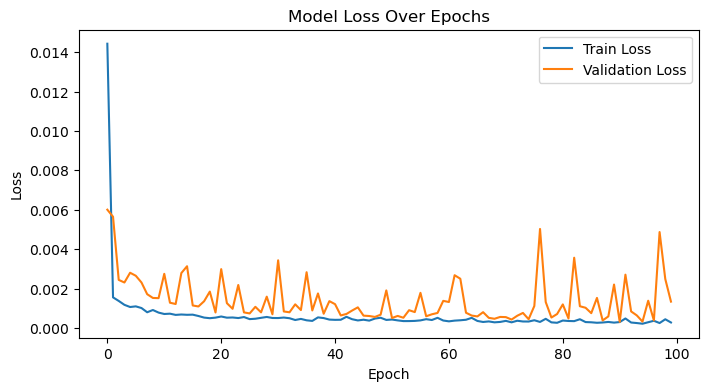

In [39]:
# 使用 grid_search 得到的最佳参数
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# 使用最佳参数构建最佳模型
best_model = build_cnn_model(optimizer=best_params['optimizer'], dropout_rate=best_params['dropout_rate'])

# 重新训练模型
history = best_model.fit(
    trainX, 
    trainY, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(testX, testY), 
    #callbacks=[early_stop],
    verbose=1
)

# 绘制损失图
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [40]:
#检查模型的最佳参数
grid_search.best_params_

{'batch_size': 32,
 'dropout_rate': 0.2,
 'epochs': 100,
 'filters_1': 64,
 'kernel_size_1': 5,
 'optimizer': 'Adam',
 'pool_size_1': 2}

In [41]:
my_model=grid_search.best_estimator_.model

In [42]:
my_model

In [43]:
prediction=my_model.predict(testX)

15/15 [==============================] - 0s 2ms/step


In [44]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.7833882 ]
 [0.785541  ]
 [0.78923947]
 [0.78940415]
 [0.7729457 ]
 [0.7546697 ]
 [0.7417554 ]
 [0.7396526 ]
 [0.73131055]
 [0.72907907]
 [0.73035467]
 [0.73117745]
 [0.73448807]
 [0.74502   ]
 [0.74821115]
 [0.7490466 ]
 [0.742906  ]
 [0.7332503 ]
 [0.7353517 ]
 [0.7375125 ]
 [0.74476856]
 [0.7547417 ]
 [0.7646077 ]
 [0.7681636 ]
 [0.7695758 ]
 [0.7666172 ]
 [0.7739009 ]
 [0.78393847]
 [0.7850294 ]
 [0.7895248 ]
 [0.7982146 ]
 [0.81231385]
 [0.81372154]
 [0.81378585]
 [0.8100032 ]
 [0.8188057 ]
 [0.8244259 ]
 [0.83392304]
 [0.8420037 ]
 [0.8466132 ]
 [0.8530546 ]
 [0.861505  ]
 [0.86439747]
 [0.87402904]
 [0.8766583 ]
 [0.8873201 ]
 [0.8966895 ]
 [0.90910536]
 [0.91872644]
 [0.92662007]
 [0.9286202 ]
 [0.92882705]
 [0.924165  ]
 [0.91516083]
 [0.90697855]
 [0.904619  ]
 [0.9052976 ]
 [0.9041967 ]
 [0.8957941 ]
 [0.88645685]
 [0.8780976 ]
 [0.87071973]
 [0.8676364 ]
 [0.8599824 ]
 [0.8546706 ]
 [0.8488601 ]
 [0.8494552 ]
 [0.8596646 ]
 [0.8551628 ]
 [0.8522354 ]
 [0.8412

In [45]:
prediction.shape
#testY 和 prediction 的长度是一样的。 现在可以将 testY 与预测进行比较。

(453, 1)

In [46]:

prediction_copies_array = np.repeat(prediction,5, axis=-1)

In [47]:

prediction_copies_array.shape


(453, 5)

In [48]:

prediction_copies_array

array([[0.7833882 , 0.7833882 , 0.7833882 , 0.7833882 , 0.7833882 ],
       [0.785541  , 0.785541  , 0.785541  , 0.785541  , 0.785541  ],
       [0.78923947, 0.78923947, 0.78923947, 0.78923947, 0.78923947],
       ...,
       [0.9544764 , 0.9544764 , 0.9544764 , 0.9544764 , 0.9544764 ],
       [0.9467626 , 0.9467626 , 0.9467626 , 0.9467626 , 0.9467626 ],
       [0.94049853, 0.94049853, 0.94049853, 0.94049853, 0.94049853]],
      dtype=float32)

In [49]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]
# 逆变换后的第一列是我们需要的，所以我们在最后使用了 → [:,0]

In [50]:
pred.shape

(453,)

In [51]:
#testY 也是按比例缩放的，也需要使用与上述相同的代码进行逆变换。
original_copies_array = np.repeat(testY,5, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

In [52]:
pred

array([147.0779 , 147.43123, 148.03825, 148.06529, 145.36398, 142.36438,
       140.24478, 139.89964, 138.53049, 138.16423, 138.3736 , 138.50864,
       139.052  , 140.7806 , 141.30435, 141.44148, 140.43362, 138.84886,
       139.19376, 139.5484 , 140.73932, 142.3762 , 143.9955 , 144.57912,
       144.81088, 144.3253 , 145.52077, 147.16821, 147.34727, 148.08508,
       149.51134, 151.82541, 152.05646, 152.06702, 151.44617, 152.89091,
       153.81334, 155.37209, 156.69835, 157.45491, 158.51212, 159.89906,
       160.37381, 161.95462, 162.38615, 164.13605, 165.67383, 167.71162,
       169.29073, 170.58627, 170.91457, 170.94852, 170.18335, 168.70549,
       167.36255, 166.9753 , 167.08665, 166.90598, 165.52687, 163.99437,
       162.62238, 161.41147, 160.9054 , 159.64917, 158.77734, 157.82368,
       157.92136, 159.59702, 158.85814, 158.37766, 156.57866, 155.08543,
       154.79506, 155.59625, 156.03491, 156.06076, 154.14941, 153.63403,
       153.10225, 152.74261, 150.70128, 148.17001, 

In [53]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [147.0779  147.43123 148.03825 148.06529 145.36398 142.36438 140.24478
 139.89964 138.53049 138.16423 138.3736  138.50864 139.052   140.7806
 141.30435 141.44148 140.43362 138.84886 139.19376 139.5484  140.73932
 142.3762  143.9955  144.57912 144.81088 144.3253  145.52077 147.16821
 147.34727 148.08508 149.51134 151.82541 152.05646 152.06702 151.44617
 152.89091 153.81334 155.37209 156.69835 157.45491 158.51212 159.89906
 160.37381 161.95462 162.38615 164.13605 165.67383 167.71162 169.29073
 170.58627 170.91457 170.94852 170.18335 168.70549 167.36255 166.9753
 167.08665 166.90598 165.52687 163.99437 162.62238 161.41147 160.9054
 159.64917 158.77734 157.82368 157.92136 159.59702 158.85814 158.37766
 156.57866 155.08543 154.79506 155.59625 156.03491 156.06076 154.14941
 153.63403 153.10225 152.74261 150.70128 148.17001 146.09395 146.76418
 147.1634  148.83273 147.08498 144.79674 143.44199 142.63753 142.85825
 143.48062 142.8439  143.57755 143.868   144.59203 145.73921 146.

In [54]:

import matplotlib.pyplot as plt

In [55]:
data_to_save = pd.DataFrame({
    'Original_Stock_Price': original,
    'CNN_Predicted_Stock_Price': pred
})

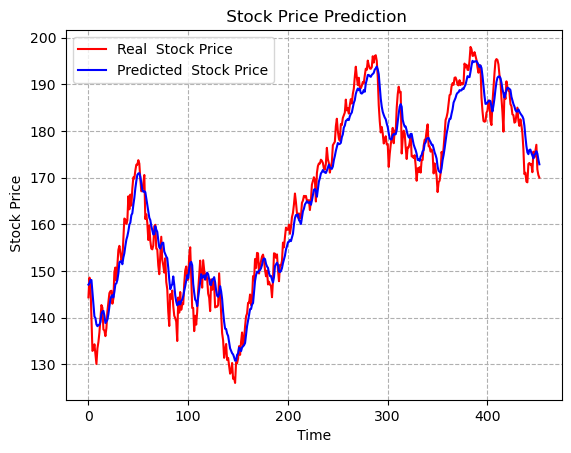

In [56]:
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()